In [1]:
import sys
sys.path += ['layers']
import numpy as np
from init_layers import init_layers
from init_model import init_model
from inference import inference
from loss_euclidean import loss_euclidean
from loss_crossentropy import loss_crossentropy
from data_utils import get_CIFAR10_data

import pickle
import matplotlib.pyplot as plt

use_pcode = True
if use_pcode:
    # import the provided pyc implementation
    sys.path += ['pyc_code']
    from inference_ import inference
    from calc_gradient_ import calc_gradient
    from update_weights_ import update_weights
else:
    # import your own implementation
    from inference import inference
    from calc_gradient import calc_gradient
    from update_weights import update_weights

%load_ext autoreload
%autoreload 2

In [38]:
X_train, y_train, X_test, y_test = get_CIFAR10_data()

Train data shape:  (32, 32, 3, 50000)
Train labels shape:  (50000,)
Test data shape:  (32, 32, 3, 10000)
Test labels shape:  (10000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


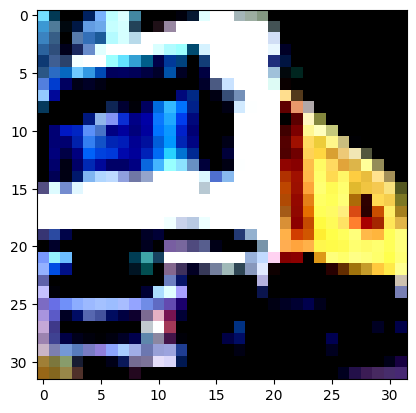

In [39]:
img = 1
plt.imshow(X_train[:,:,:,img])
print(y_train[img])

Simple example with linear function. Note shapes aren't correct to do backprop

In [40]:
from fn_linear_ import fn_linear
linear = init_layers("linear", {"num_in": 32, "num_out": 10})

In [41]:
linear.keys()

dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])

In [42]:
linear['fwd_fn']

<function fn_linear_.fn_linear(input, params, hyper_params, backprop, dv_output=None)>

In [43]:
linear['hyper_params']

{'num_in': 32, 'num_out': 10}

In [44]:
x = np.random.randn(32,1)

In [45]:
W = linear['params']['W'].shape
b = linear['params']['b'].shape

In [46]:
y = linear['params']['W'] @ x + linear['params']['b']
y.shape

(10, 1)

In [47]:
linear['fwd_fn'](
    input=x, 
    params=linear['params'], 
    hyper_params=linear['hyper_params'],
    backprop=False
    )

(array([[ 0.31091351],
        [-0.24683413],
        [ 0.14511577],
        [-0.90967512],
        [ 0.70062043],
        [-0.16860566],
        [-0.8706041 ],
        [-0.70034567],
        [ 0.82629805],
        [ 0.07134173]]),
 array([], dtype=float64),
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)})

### Initializing a model

Basic size and content information can be seen below for each layer in the model. When the layer is initialized, the weights are also initialized for that layer.


In [3]:
l = [
    init_layers("conv", {"filter_size": 2, "filter_depth": 3, "num_filters": 2}),
    init_layers("pool", {"filter_size": 2, "stride": 2}),
    init_layers("relu", {}),
    init_layers("flatten", {}),
    init_layers("linear", {"num_in": 32, "num_out": 10}),
    init_layers("softmax", {}),
]

In [49]:
l[0].keys()

dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])

In [50]:
for layer in l:
    print(f"layer type: {layer['type']}")

layer type: conv
layer type: pool
layer type: relu
layer type: flatten
layer type: linear
layer type: softmax


In [51]:
for layer in l:
    print(f"layer type: {layer['fwd_fn']}")

layer type: <function fn_conv at 0x00000224DB6174C8>
layer type: <function fn_pool at 0x00000224CC36B708>
layer type: <function fn_relu at 0x00000224CC3C94C8>
layer type: <function fn_flatten at 0x00000224BCFBDEE8>
layer type: <function fn_linear at 0x00000224CC43D678>
layer type: <function fn_softmax at 0x00000224CC3920D8>


In [52]:
for layer in l:
    print(f"layer params: {layer['params'].keys()}")

layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])
layer params: dict_keys(['W', 'b'])


In [53]:
for layer in l:
    print(f"layer params: {layer['hyper_params'].keys()}")

layer params: dict_keys(['filter_size', 'filter_depth', 'num_filters'])
layer params: dict_keys(['filter_size', 'stride'])
layer params: dict_keys([])
layer params: dict_keys([])
layer params: dict_keys(['num_in', 'num_out'])
layer params: dict_keys([])


Now lets initialize a model with these layers.

In [4]:
model = init_model(
    layers=l,
    input_size=[10,10,3], # does not include batches only [H,W,D] 
    output_size=10, 
    display=True
    )

Input size:
[10, 10, 3]
Layer 0 output size: 
(9, 9, 2)
Layer 1 output size: 
(4, 4, 2)
Layer 2 output size: 
(4, 4, 2)
Layer 3 output size: 
(32,)
Layer 4 output size: 
(10,)
Final output size:
(10,)
Provided output size (should match above):
10
(Batch dimension not included)


In [6]:
model.keys()

dict_keys(['layers', 'input_size', 'output_size'])

In [5]:
layer_n = 0
print(f"layer {layer_n} dict: {model['layers'][layer_n].keys()}")
print(f"input size: {model['input_size']}")
print(f"output size: {model['output_size']}")

layer 0 dict: dict_keys(['fwd_fn', 'type', 'params', 'hyper_params'])
input size: [10, 10, 3]
output size: 10


### Run Inference (Forward pass)

In [7]:
                 # [H, W, Channels, Batch]
inp = np.random.rand(10, 10, 3, 4)  # Dummy input

In [34]:
output, activations = inference(model, inp)

In [9]:
print(f"output size: {output.shape}")

for ilayer, act in enumerate(activations):
    print(f"layer {ilayer} activation shape {act.shape}")

output size: (10, 4)
layer 0 activation shape (9, 9, 2, 4)
layer 1 activation shape (4, 4, 2, 4)
layer 2 activation shape (4, 4, 2, 4)
layer 3 activation shape (32, 4)
layer 4 activation shape (10, 4)
layer 5 activation shape (10, 4)


### Calculate loss

In [35]:
# dummy idx corresponding to which neuron has the highest activation
labels = np.array([0,5,6,8]) 

# this function averages the loss across a batch
loss, dv = loss_crossentropy(output, labels, hyper_params=None, backprop=True)

print(f"loss for this forward pass is: {loss}")

loss for this forward pass is: 2.296089679706197


In [11]:
print(f"shape of derivative to start gradient with is {dv.shape}")

shape of derivative to start gradient with is (10, 4)


In [36]:
# note we only have derivatives for the "true" labels
dv

array([[-10.00733793,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -8.60662314,   0.        ,   0.        ],
       [  0.        ,   0.        , -10.87445509,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , -10.39882376],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

### Calculate Accuracy

In [37]:
y_hat = np.argmax(output, axis=0)
y_hat # what the model chose


array([5, 5, 1, 5], dtype=int64)

In [38]:
# correct is when y_hat = labels
np.sum((y_hat - labels) == 0) / len(labels)

0.25

### Calculate Gradient

In [39]:
grads = calc_gradient(model, inp, activations, dv)
gradsL.append(grads)

In [40]:
len(grads), len(gradsL)

(6, 2)

In [67]:
for ilayer, act in enumerate(activations):
    print(f"layer {ilayer}: {l[ilayer]['type']} activation shape {act.shape}")

    for key,value in grads[ilayer].items():
        print(f"    {key} gradient shape: {value.shape}")

layer 0: conv activation shape (9, 9, 2, 4)
    W gradient shape: (2, 2, 3, 2)
    b gradient shape: (2, 1)
layer 1: pool activation shape (4, 4, 2, 4)
    W gradient shape: (0,)
    b gradient shape: (0,)
layer 2: relu activation shape (4, 4, 2, 4)
    W gradient shape: (0,)
    b gradient shape: (0,)
layer 3: flatten activation shape (32, 4)
    W gradient shape: (0,)
    b gradient shape: (0,)
layer 4: linear activation shape (10, 4)
    W gradient shape: (10, 32)
    b gradient shape: (10, 1)
layer 5: softmax activation shape (10, 4)
    W gradient shape: (0,)
    b gradient shape: (0,)


### Update weights 

In [19]:
update_params = {"learning_rate": 0.1,
                    "weight_decay": 0.001 }

In [72]:
update_params['average_grad'] = gradsL[0].copy()

In [75]:
# gradsL[-1], 
update_params['average_grad']

[{'W': array([[[[0.19486676, 0.        ],
           [0.09737152, 0.        ],
           [0.02460886, 0.        ]],
  
          [[0.11566207, 0.        ],
           [0.05951574, 0.        ],
           [0.11762663, 0.        ]]],
  
  
         [[[0.05685761, 0.        ],
           [0.23389914, 0.        ],
           [0.11088049, 0.        ]],
  
          [[0.07162039, 0.        ],
           [0.09607367, 0.        ],
           [0.00914853, 0.        ]]]]),
  'b': array([[0.19525678],
         [0.        ]])},
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)},
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)},
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)},
 {'W': array([[-0.0814674 , -0.04726772, -0.05395581, -0.05929124, -0.08078541,
          -0.06439375, -0.05129363, -0.06087379, -0.05174607, -0.0637727 ,
          -0.05532055, -0.04702331, -0.06720641, -0.03478838, -0.07633366,
          -0.05230182,  0.        ,  0.        ,  0.

In [104]:
pre_average = update_params["average_grad"].copy()
pre_average[0]["W"][0]


array([[[ 0.11828177,  0.        ],
        [ 0.05538898,  0.        ],
        [-0.05101028,  0.        ]],

       [[ 0.0627945 ,  0.        ],
        [ 0.01403163,  0.        ],
        [ 0.05244346,  0.        ]]])

In [105]:
new_grad = gradsL[-1] # this is grad in the train.py
n_averaged = 1
for ilayer in range(len(new_grad)):
    layer_avg_grad = update_params['average_grad'][ilayer]["W"]
    layer_new_grad = new_grad[ilayer]["W"]
    if len(layer_avg_grad) != 0:
         update_params['average_grad'][ilayer]["W"] = \
         (layer_new_grad + (n_averaged * layer_avg_grad))/(n_averaged + 1)
n_averaged += 1


In [106]:
pre_average[0]["W"], update_params['average_grad'][0]["W"] #howare these both changing yet the same?

(array([[[[ 0.11281142,  0.        ],
          [ 0.05239023,  0.        ],
          [-0.05641165,  0.        ]],
 
         [[ 0.05901825,  0.        ],
          [ 0.01078276,  0.        ],
          [ 0.04778752,  0.        ]]],
 
 
        [[[ 0.01754384,  0.        ],
          [ 0.17013335,  0.        ],
          [ 0.05712072,  0.        ]],
 
         [[ 0.01406363,  0.        ],
          [ 0.01376295,  0.        ],
          [-0.0283961 ,  0.        ]]]]),
 array([[[[ 0.11281142,  0.        ],
          [ 0.05239023,  0.        ],
          [-0.05641165,  0.        ]],
 
         [[ 0.05901825,  0.        ],
          [ 0.01078276,  0.        ],
          [ 0.04778752,  0.        ]]],
 
 
        [[[ 0.01754384,  0.        ],
          [ 0.17013335,  0.        ],
          [ 0.05712072,  0.        ]],
 
         [[ 0.01406363,  0.        ],
          [ 0.01376295,  0.        ],
          [-0.0283961 ,  0.        ]]]]))

In [61]:
update_params['new_avg_grad'].shape

(10, 32)

In [57]:
avg_layer, new_layer

({'W': array([], dtype=float64), 'b': array([], dtype=float64)},
 {'W': array([], dtype=float64), 'b': array([], dtype=float64)})

In [27]:
len(layer['W'])

0

In [32]:
hyper_params = {"learning_rate": 0.1, "weight_decay": 0.01 }

In [33]:
print(model['layers'][0]['params']['b']) 
updated_model = update_weights(model, grads, hyper_params) # note this overwrites the model!
print(updated_model['layers'][0]['params']['b'])

[[ 0.11374794]
 [-0.07572622]]
[[ 0.09422226]
 [-0.07572622]]


In [72]:
l = [
    init_layers("conv", {"filter_size": 3, "filter_depth": 3, "num_filters": 3}),
    init_layers("pool", {"filter_size": 2, "stride": 2}),
    init_layers("relu", {}),
    # init_layers("flatten", {}),
    # init_layers("linear", {"num_in": 588, "num_out": 10}),
    # init_layers("softmax", {}),
]

In [73]:
model = init_model(
    layers=l,
    input_size=[32,32,3], # does not include batches only [H,W,D] 
    output_size=10, 
    display=True
    )

Input size:
[32, 32, 3]
Layer 0 output size: 
(30, 30, 3)
Layer 1 output size: 
(15, 15, 3)
Final output size:
(15, 15, 3)
Provided output size (should match above):
10
(Batch dimension not included)


AssertionError: Network output does not match up with provided output size

In [108]:
from init_base_model import init_base_model
from train_custom import train_custom

X_train, y_train, X_test, y_test = get_CIFAR10_data()


Train data shape:  (32, 32, 3, 50000)
Train labels shape:  (50000,)
Test data shape:  (32, 32, 3, 10000)
Test labels shape:  (10000,)


In [176]:
model = init_base_model()
n_train = 20
n_test = 100
### TRAIN DATA
X_train_tiny = X_train[:,:,:, :n_train]
y_train_tiny = y_train[:n_train]
### TEST/VALIDATION DATA
X_test_tiny = X_test[:,:,:,:n_test]
y_test_tiny = y_test[:n_test]

Input size:
[32, 32, 3]
Layer 0 output size: 
(28, 28, 3)
Layer 1 output size: 
(14, 14, 3)
Layer 2 output size: 
(14, 14, 3)
Layer 3 output size: 
(588,)
Layer 4 output size: 
(10,)
Final output size:
(10,)
Provided output size (should match above):
10
(Batch dimension not included)


In [182]:
learning_rate = 1e1
weight_decay = 1e-5
batch_size = 10
save_file = '\\test_base_model'
live_plot_on = False
itr_to_plot = 50
verbose = True
early_stopping_on = True
calculate_test = True
itr_to_test = 100
numIters = 500

params = {
    "learning_rate" :learning_rate, # default 0.01
    "weight_decay":weight_decay , # default 0.0005
    "batch_size" : batch_size,    # default 128
    "save_file" : save_file,      # default model
    # "save_plot" using default!
    "live_plot_on" : live_plot_on,
    "itr_to_plot" : itr_to_plot,  # how many iterations between plots
    "verbose" : verbose,
    "early_stopping_on" : early_stopping_on, #defualt True
    "calculate_test": calculate_test,       # bool for validation checks
    "itr_to_test": itr_to_test,   # how many iterations btwn validation check
    "X_test" : X_test_tiny,
    "y_test" : y_test_tiny,
    }

running a test!
Fished itr 0 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 1 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 2 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 3 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 4 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 5 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 6 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 7 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 8 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 9 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 10 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 11 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 12 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 13 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 14 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 15 / 500; cost: nan train: 0.0 val: 0.1, lr: 10.0
Fished itr 16 / 50

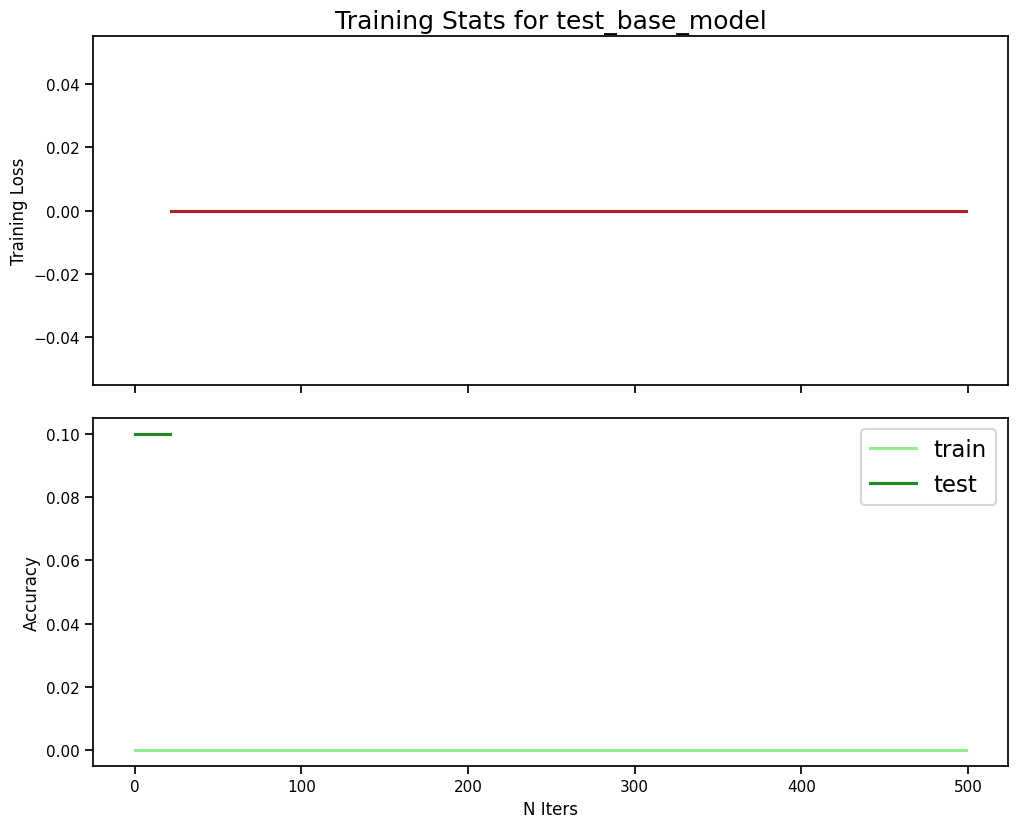

In [186]:
trained_model, loss, accuracy, test_accuracy, time = train_custom(model,X_train_tiny , y_train_tiny, params, numIters)

In [185]:
np.isnan(loss).any()

False

In [144]:
import os
plot_save_path
plot_save_path = os.path.join(os.getcwd(), 'results' )
plot_save_path
# ps

'c:\\Users\\jbred\\github\\COS429\\Assignment_3\\initial\\results'

In [141]:
os.getcwd() + 'skdfj'

'c:\\Users\\jbred\\github\\COS429\\Assignment_3\\initialskdfj'

In [161]:
plot_save_path + save_file

'c:\\Users\\jbred\\github\\COS429\\Assignment_3\\initial\\results\\test_base_model'

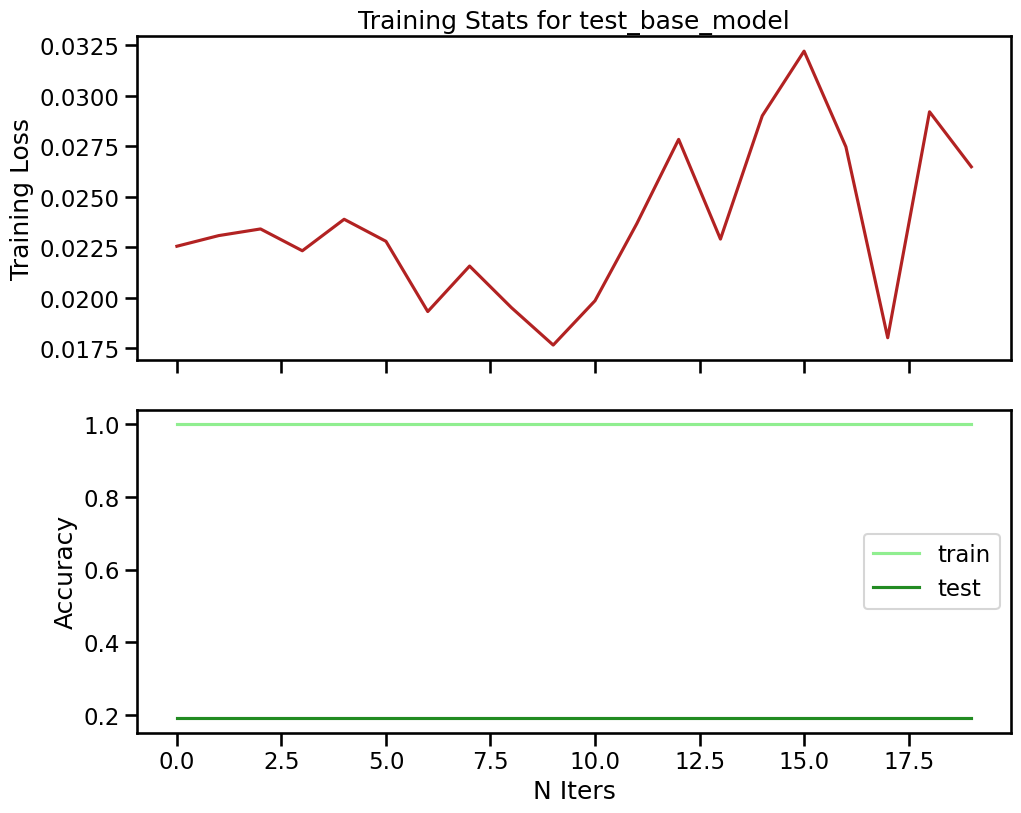

In [164]:
fig, ax = plt.subplots(2,1, figsize = (10,8), sharex=True)

# plot aesthetics
plt.tight_layout()
import seaborn as sns
sns.set_context("talk")
_ = ax[0].set(title = f"Training Stats for {save_file[1:]}", ylabel="Training Loss")
_ = ax[1].set(ylabel = "Accuracy", xlabel = "N Iters")

# save_path =
# 
#
ax[0].plot(range(numIters), loss, color="firebrick")
ax[1].plot(range(numIters), accuracy, color="lightgreen", label="train")
ax[1].plot(range(numIters), ta, color="forestgreen", label="test") 

# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
plt.legend()
plt.savefig(plot_save_path + save_file,bbox_inches='tight')